### Notebook to collect cloud types and MOD06 data from 20160101 data

In [2]:
import os
import re
import cv2
import sys
import json
import glob
import copy
import numpy as np
import pandas as pd
import tensorflow as tf
from pyhdf.SD import SD, SDC
from scipy.stats import mode
from netCDF4 import Dataset
from tensorflow.contrib.data import parallel_interleave

#/home/tkurihana/Research/clouds/src_analysis/lib_hdfs
%reload_ext autoreload
%autoreload 2
libdir="/home/tkurihana/Research/clouds/src_analysis/lib_hdfs"
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from lib_datesinfo import deltaday2date, date2deltaday
from pandas_lib import  highlight_max, highlight_min
from analysis_lib import mod06_proc_sds
from lib_datesinfo import deltaday2date

#### Decoder function

In [3]:
def importNetcdf(path=None, var_name=None):
    nc_fid=Dataset(path, 'r')
    field = nc_fid.variables[var_name][:]
    return field

In [4]:
def gen_mod06_img(hdf_file, varname='xxx'):
    hdf = SD(hdf_file, SDC.READ)
    sds = hdf.select(varname)
    decoded_array = mod06_proc_sds(sds,variable=varname)
    return decoded_array

#### For tfrecord output

In [5]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [6]:
def write_patches(patches, filename, out_dir, patches_per_record):
    """Writes `patches_per_record` patches into a tfrecord file in `out_dir`.
    Args:
        patches: Iterable of (filename, coordinate, patch) which defines tfrecord example
            to write.
        out_dir: Directory to save tfrecords.
        patches_per_record: Number of examples to save in each tfrecord.
    Side Effect:
        Examples are written to `out_dir`. File format is `out_dir`/`rank`-`k`.tfrecord
        where k means its the "k^th" record that `rank` has written.
    """
    rank = 0 #MPI.COMM_WORLD.Get_rank()
    for i, patch in enumerate(patches):
        #print(len(patch))
        if i % patches_per_record == 0:
            rec = f"{filename}.tfrecord"
            if i % 100 == 0:
                print("Writing to", rec, flush=True)
            f = tf.python_io.TFRecordWriter(os.path.join(out_dir, rec))

        write_feature(f, *patch )

        print("Rank", rank, "wrote", i + 1, "patches", flush=True)

- cloud types write features

In [7]:
def write_feature(writer, filename, coord, 
                  cot_patch, ctp_patch, cer_patch,
                  cwp_patch, cpi_patch):
    feature = {
        "filename": _bytes_feature(bytes(filename, encoding="utf-8")),
        "coordinate": _int64_feature(coord),
        "shape": _int64_feature(cot_patch.shape),
        "cloud_layer_type": _bytes_feature(cot_patch.ravel().tobytes()),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())

### TF loader

In [8]:
def data_extractor_resize_fn(filelist,prefetch=1,height=32,width=32,channel=6,read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        filename = decoded['filename']
        coord    = decoded['coordinate']
        return filename, coord
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    filename_list = []
    coord_list = []
    with tf.Session() as sess:
        try:
            while True:
                filename, coord = sess.run(next_element)
                filename_list.append(filename.decode("utf-8"))
                coord_list.append(coord)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return filename_list, coord_list

In [9]:
tf_datadir = "/home/tkurihana/Research/data/tfrecords/clouds_MYD_laads_multiprocessed_20160101"

In [10]:
tf_filelist = glob.glob(os.path.join(tf_datadir, "*.tfrecord"))

In [11]:
# check filelist
for i in tf_filelist:
    print(os.path.basename(i))

2-1_normed.tfrecord
3-0_normed.tfrecord
0-0_normed.tfrecord
0-1_normed.tfrecord
1-0_normed.tfrecord
3-1_normed.tfrecord
2-0_normed.tfrecord
0-2_normed.tfrecord


In [14]:
height = width = 128
channels = 6
filename_list = []
coord_list = []
tfrecord_dict = {}
for ifile in tf_filelist:
    filename_list, coord_list = data_extractor_resize_fn([ifile],height=height,width=width,channel=channels )
    tfrecord_dict[f'{os.path.basename(ifile)}-filename']= filename_list
    tfrecord_dict[f'{os.path.basename(ifile)}-coordinate'] = coord_list
print("NORMAL END")

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
NORMAL END


check dictionary

In [15]:
# check tfrecord_dict
a = [i for i in tfrecord_dict.keys()]
print(a)

['2-1_normed.tfrecord-filename', '2-1_normed.tfrecord-coordinate', '3-0_normed.tfrecord-filename', '3-0_normed.tfrecord-coordinate', '0-0_normed.tfrecord-filename', '0-0_normed.tfrecord-coordinate', '0-1_normed.tfrecord-filename', '0-1_normed.tfrecord-coordinate', '1-0_normed.tfrecord-filename', '1-0_normed.tfrecord-coordinate', '3-1_normed.tfrecord-filename', '3-1_normed.tfrecord-coordinate', '2-0_normed.tfrecord-filename', '2-0_normed.tfrecord-coordinate', '0-2_normed.tfrecord-filename', '0-2_normed.tfrecord-coordinate']


In [16]:
tfrecord_dict['2-1_normed.tfrecord-filename'][0]

'/home/tkurihana/Research/data/MYD02/20160101/MYD021KM.A2016001.1305.061.2018055020801.hdf'

In [17]:
tfrecord_dict['2-1_normed.tfrecord-coordinate'][0]

array([1280,  384])

### Main process

In [18]:
def find_date(ifile):
    """ 
    find_date(tfrecord_dict['2-1_normed.tfrecord-filename'][0])
    ['20160101', '001.1305', '061.2018', '05502080']
    """
    result =re.findall('[0-9]{3}.[0-9]{4}',ifile)
    return result[1]

In [19]:
def wrapper_netcdf(ifile, netcdf_datadir=None, bname='A2016', var_name='cloud_layer_type'):
    comfilename = find_date(ifile)
    #print(bname+comfilename+'.nc')
    path = os.path.join(netcdf_datadir, bname+'.'+comfilename+'.nc')
    ncdata = importNetcdf(path=path, var_name=var_name)
    # Need transpose to correspoind Netcdf data to tfrecord data
    return ncdata.T

In [22]:
### Practice
ifile=tfrecord_dict['2-1_normed.tfrecord-filename'][0]
netcdf_datadir = "/home/tkurihana/Research/data3/201601"
a = wrapper_netcdf(ifile, netcdf_datadir)

In [272]:
path = '/home/tkurihana/Research/data3/200801/day/A2008.001.2225.nc'
#path = '/home/tkurihana/Research/data3/201601/A2016.001.0000.nc'
a1 = importNetcdf(path, var_name='cloud_layer_type').T
#aa = importNetcdf(path, var_name='cloud_layer_type').T

In [273]:
a1.shape

(10, 2030, 1354, 1)

In [267]:
a1.mask[0,:,:,0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [271]:
a1.data

array([[[[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        ...,

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]]],


       [[[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        ...,

        [[-1],
 

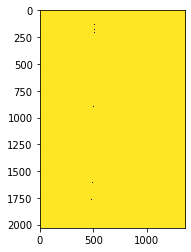

In [270]:
plt.imshow(a1.mask[0,:,:,0])

In [256]:
a1 = a1.astype(np.float64)
a1[np.where(a1 == a1.fill_value)] = np.nan

In [170]:
am1 = importNetcdf(path, var_name='cloud_mask').T

In [235]:
am1.data.shape

(2030, 1354, 1)

In [172]:
np.where(am1.mask)

(array([   1,    1,    1, ..., 2029, 2029, 2029]),
 array([1138, 1139, 1140, ..., 1351, 1352, 1353]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [173]:
adx = np.where(am1.mask)

In [174]:
am1 = am1.astype(np.float64)

In [175]:
marray = np.zeros(am1.shape).astype(np.float64)
marray[:,:] = np.nan
marray[adx] = 1

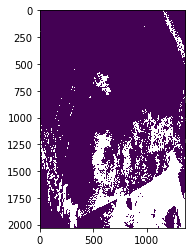

In [176]:
plt.imshow(am1[:,:,0])

In [160]:
np.where(am1 == am1.fill_value)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [217]:
aa2 = a1.data
np.where(aa2 >= 0)

(array([0, 0, 0, ..., 2, 2, 2]),
 array([  10,   11,   13, ..., 1461, 1467, 1505]),
 array([780, 781, 780, ..., 742, 742, 738]),
 array([0, 0, 0, ..., 0, 0, 0]))

([<matplotlib.axis.XTick at 0x7feaa1394358>,
 <a list of 8 Text xticklabel objects>)

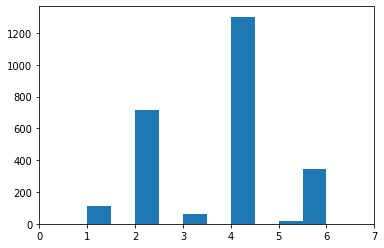

In [244]:
plt.hist(a1.data[np.where(a1.data > -1 )].ravel())
plt.xticks([i for i in range(8)])

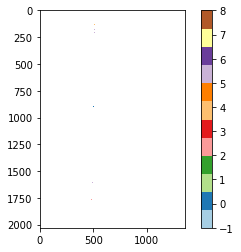

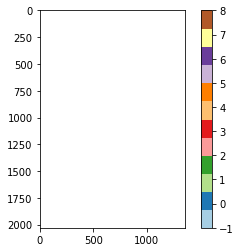

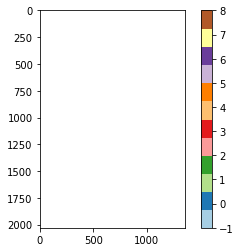

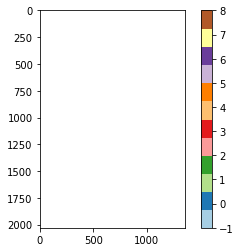

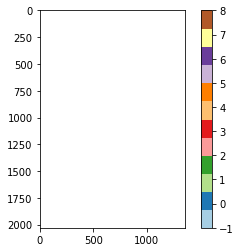

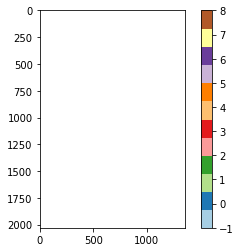

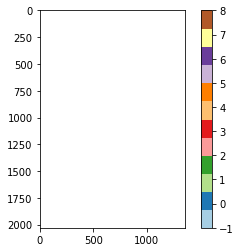

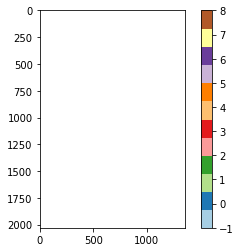

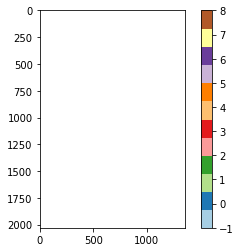

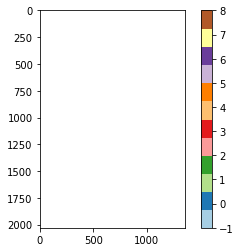

In [274]:
#fig = plt.figure()
for i in range(10):
    plt.figure()
    plt.imshow(a1[i,:,:,0],cmap='Paired', vmin=-1, vmax=8)
    plt.colorbar()
    plt.show()
    plt.close()

In [123]:
nc_fid=Dataset(path, 'r')

In [144]:
### Practice result
a1.shape

(10, 2030, 1354, 1)

In [128]:
a.data

array([[[[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        ...,

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]]],


       [[[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        [[-1],
         [-1],
         [-1],
         ...,
         [-1],
         [-1],
         [-1]],

        ...,

        [[-1],
 

(array([       0.,        0.,        0.,        0.,        0., 27486200.,
               0.,        0.,        0.,        0.]),
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5]),
 <a list of 10 Patch objects>)

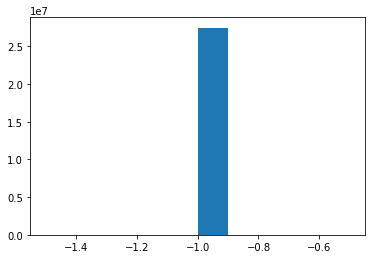

In [140]:
plt.hist(aa.ravel())

(array([ 112.,    0.,  715.,    0.,   59.,    0., 1303.,    0.,   19.,
         342.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

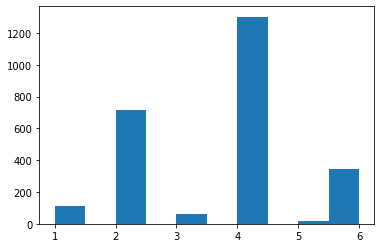

In [145]:
plt.hist(a1.ravel())

todo: write code to make data for frequent cloud classes as npy datast 

In [20]:
def comp_freqlabel(data, undef=-1):
    data = data.astype(np.float64)
    nan_idx = np.where(data == undef)
    data[nan_idx] = np.nan
    # mode function
    prep = mode(data,axis=3)
    mode_array = prep[0]
    # check data points where all layers are np.NaN
    nan_idx2 = np.where(np.isnan(mode_array))
    mode_array[nan_idx2] = undef
    mode_array = mode_array.astype(int)
    return mode_array

In [201]:
g = np.ones((4,4,4,1))
g[1:,:,:,:] = 2
p1,p2 = mode(g,axis=0)
p1.shape

(1, 4, 4, 1)

In [202]:
p1

array([[[[2.],
         [2.],
         [2.],
         [2.]],

        [[2.],
         [2.],
         [2.],
         [2.]],

        [[2.],
         [2.],
         [2.],
         [2.]],

        [[2.],
         [2.],
         [2.],
         [2.]]]])

In [ ]:
b = comp_freqlabel(a)

In [146]:
def mode_fn(array):
    """ a:= data[10,1]"""
    nan_idx = np.where(array.ravel())
    if len(nan_idx[0]) == 10:
        mode = -1
    else:
        idx_list = []
        for i in range(10):
            if not i in nan_idx[0]:
                idx_list.append(i)
        idx = np.asarray(idx_list)
        #print(idx, nan_idx)
        (_, idx, counts) = np.unique(array[idx], return_index=True, return_counts=True)
        index = idx[np.argmax(counts)]
        mode = array[index]
    return mode

In [147]:
def comp_freqlabel2(data, undef=-1):
    data = data.astype(np.float64)
    nan_idx = np.where(data == undef)
    data[nan_idx] = np.nan
    # mode function
    n,h,w,c = data.shape
    tmp_data = data.reshape(n,h*w)
    data_list = []
    for i in range(h*w):
        tmp = tmp_data[:,i]
        #print(tmp.shape)
        prep = mode_fn(tmp)
        data_list.append(prep)
    mode_array =  np.asarray(data_list).reshape(h,w) #prep[0]
    # check data points where all layers are np.NaN
    nan_idx2 = np.where(np.isnan(mode_array))
    mode_array[nan_idx2] = undef
    mode_array = mode_array.astype(int)
    return mode_array

In [148]:
b = comp_freqlabel2(a1)

In [149]:
b.shape

(2030, 1354)

In [150]:
b

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

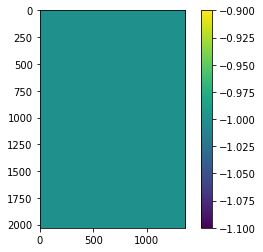

In [151]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(b[:,:])
plt.colorbar()
plt.show()

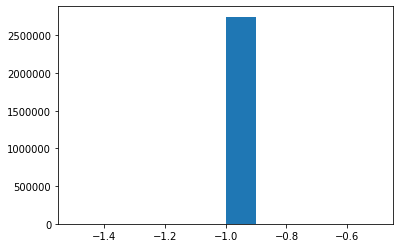

In [152]:
plt.figure()
plt.hist(b.ravel())
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

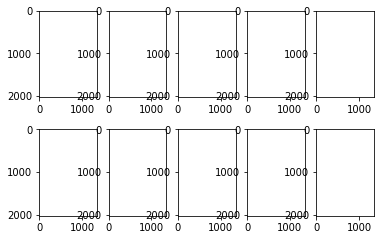

In [85]:
fig = plt.figure()
for i in range(10):
    ii = i+1
    ax = plt.subplot(2,5,ii)
    ax.imshow(a[i,:,:,0], cmap='jet', vmin=-1, vmax=8)
plt.colorbar()
plt.show()

In [203]:
data = np.load("/home/tkurihana/Research/data3/200801/cloud_types_npy/A2008.001.0035.npy")

In [204]:
data.shape

(1, 2030, 1354, 1)

([<matplotlib.axis.XTick at 0x7feb44c0acc0>,
 <a list of 3 Text xticklabel objects>)

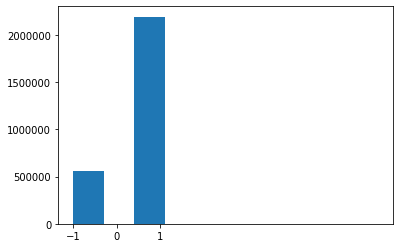

In [205]:
plt.hist(data.ravel())
plt.xticks([-1,0,1])

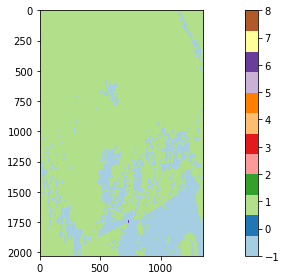

In [225]:
fig = plt.figure(figsize=(12,4))
for i in range(1):
    ii = i+1
    ax = plt.subplot(1,1,ii)
    plt.imshow(data[0,:,:,0], cmap='Paired', vmin=-1, vmax=8)
    plt.colorbar()
fig.tight_layout()
plt.show()